In [1]:
import os
import sys
os.chdir('/home/msun415/induction/')
sys.path.append('/home/msun415/my_data_efficient_grammar')
import argparse 
from rdkit import Chem
from rdkit.Chem import rdchem
from multiprocessing import Pool
from tqdm import tqdm
from itertools import permutations
from functools import reduce
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import networkx as nx
from networkx.algorithms.isomorphism import GraphMatcher
from collections import defaultdict, Counter
import sys
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import json
from rdkit.Chem.rdmolops import FastFindRings
from itertools import accumulate, product
from copy import deepcopy
from private.molecule_graph import MolGraph
import networkx.algorithms.chordal as chordal
import os
import networkx as nx
import pandas as pd
import pickle
from src.draw.graph import draw_graph
import networkx as nx
import random
from collections.abc import Iterable
import re

def flatten(nested_iterable):
    if isinstance(nested_iterable, Iterable):
        return sum([flatten(iterable) for iterable in nested_iterable], [])
    else:
        return [nested_iterable]

# SEED = 0
# random.seed(SEED)
# np.random.seed(SEED)
# import pygsp as gsp
# from pygsp import graphs

from src.api.get_motifs import prepare_images
import openai
openai.api_key = open('notebooks/api_key.txt').readline().rstrip('\n')

/home/msun415/miniconda3/envs/ckt/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# IMAGE_PATHS = [
#     "/home/msun415/SynTreeNet/induction/CCOC(C(N=C=O)CCCCN=C=O)=O.png",
#     "/home/msun415/SynTreeNet/induction/O=C=NC1CCC(CC2CCC(CC2)N=C=O)CC1.png",
#     "/home/msun415/SynTreeNet/induction/CC1=C(C=C(C=C1)CN=C=O)N=C=O.png",
#     "/home/msun415/SynTreeNet/induction/CC1(CC(CC(CN=C=O)(C1)C)N=C=O)C.png",
#     "/home/msun415/SynTreeNet/induction/O=C=NCCCCCCCCCCCCCCCCCCCCCCCCN=C=O.png"
#     ]




In [ ]:


minn = graphs.Minnesota()
g = minn.to_networkx()
draw_graph(g, os.path.join(IMG_DIR, 'base.png'))


In [ ]:
data_dir = '/home/msun415/induction/data/nx/cora/'
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
content = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None)
edgelist["label"] = "cites"
Gnx = nx.from_pandas_edgelist(edgelist)


In [ ]:
for pid, label in content.iloc[:,[0, -1]].values:
    Gnx.nodes[pid]['label'] = label

In [ ]:
data1 = nx.node_link_data(Gnx, key='label')
json.dump(data1, open('/home/msun415/induction/data/nx/cora.json', 'w+'))
data2 = json.load(open('/home/msun415/induction/data/nx/cora.json'))

In [ ]:
sizes = []
for i in range(1,31):
    grammar, g = pickle.load(open(f'/home/msun415/induction/cache/cora/{i}.pkl', 'rb'))
    sizes.append(len(g))

plt.plot(sizes)


In [ ]:
def compare(rule_a, rule_b):
    g1 = rule_a.subgraph
    g2 = rule_b.subgraph
    try:
        if not nx.is_isomorphic(g1, g2, node_match=lambda n1,n2: n1['label']==n2['label']):
            return False
    except:
        pass
    return rule_a.embedding == rule_b.embedding

In [ ]:


test = nx.Graph()
test.add_node(0, label='gray')

# draw_graph(grammar.rules[1].subgraph, '/home/msun415/test.png')
isos = []
for rule in grammar.rules:
    same = False
    for iso in isos:
        if compare(iso, rule):
            same = True
            break
    if not same:
        isos.append(rule)
    sub = rule.subgraph
    for a, b in sub.edges:
        if sub.nodes[a]['label'] == 'gray' and sub.nodes[b]['label'] == 'gray':
            pass
    no = sum(sub.nodes[a]['label'] == 'gray' for a in sub.nodes)


# get the derivation tree of graph

In [6]:
from src.examples import *
from Subdue.src import nx_subdue

g = load_cora()
nx_subdue(g)

ModuleNotFoundError: No module named 'src'

In [ ]:
# -*- coding: utf-8 -*-
"""
Wrapper around dreadnaut that computes the orbits of a graph.
NOTE: Must have installed `dreandaut`. The location of the binary can be passed
      as an argument to `compute_automorphisms`.
Author: Jean-Gabriel Young <info@jgyoung.ca>
"""
import subprocess
import networkx as nx
from os import remove

def _build_dreadnaut_file(g):
    """Prepare file to pass to dreadnaut.
    Warning
    -------
    Assumes that the nodes are represented by the 0 indexed integers.
    """
    # dreadnaut options
    file_content = ["As"]  # sparse mode
    file_content.append("-a")  # do not print out automorphisms
    file_content.append("-m")  # do not print out level markers
    # specify graph structure
    file_content.append("n=" + str(g.number_of_nodes()) + " g")
    for v in sorted(g.nodes()):
          line = " " + str(v) + " : "
          for nb in g.neighbors(v):
              if v < nb:
                  line += str(nb) + " "
          line += ";"
          file_content.append(line)
    # add nauty command
    file_content.append(".")
    file_content.append("x")
    file_content.append("o")
    return file_content


def compute_automorphisms(g, tmp_path="/home/msun415/dreadnaut.txt", dreadnaut_call="/home/msun415/nauty2_8_8/dreadnaut"):
    # get dreadnaut command file
    file_content = _build_dreadnaut_file(g)
    # write to tmp_path
    with open(tmp_path, 'w') as f:
        print("\n".join(file_content), file=f)
    # call dreadnaut
    proc = subprocess.run([dreadnaut_call],
                          input=b"< " + tmp_path.encode(),
                          stdout=subprocess.PIPE,
                          stderr=subprocess.DEVNULL)
    [info, _, orbits] = proc.stdout.decode().strip().split("\n", 2)
    # ~~~~~~~~~~~~~~
    # Extract high level info from captured output
    # ~~~~~~~~~~~~~~
    num_orbits = int(info.split(" ")[0])
    num_gen = int(info.split(" ")[3])
    # ~~~~~~~~~~~~~~
    # Extract orbits
    # ~~~~~~~~~~~~~~
    # This big list comprehension splits all orbits into their own sublist, and
    # each of these orbits into individual components (as string).
    # There is still some post-processing to do since some of them are in the
    # compact notation X:X+n when the n+1 nodes of the orbits are contiguous.
    X = [_.strip().split(" (")[0].split(" ")
         for _ in orbits.replace("\n   ",'').strip().split(";")[:-1]]
    for i, orbit in enumerate(X):
        final_orbit = []
        for elem in orbit:
            if ":" in elem:
                _ = elem.split(":")
                final_orbit += range(int(_[0]), int(_[1]) + 1)
            else:
                final_orbit += [int(elem)]
        X[i] = final_orbit
    # garbage collection
    # remove(tmp_path)
    print(tmp_path)
    return num_orbits, num_gen, X

if __name__ == '__main__':
    import matplotlib.pyplot as plt 

    # declare networkx graph
    g = nx.barbell_graph(5, 2)

    # orbits and generators of the graph
    num_orbits, num_gen, X = compute_automorphisms(g)        
    print("Graph:\t\t", "num_orbits=" +str(num_orbits),  "num_gen=" +str(num_gen))
     
    # Plot
    colors = [None for i in range(g.number_of_nodes())]
    for idx, orbit in enumerate(X):
        for v in orbit:
            colors[v] = idx
    nx.draw(g, node_color=colors, linewidths=2, width=2, edge_color='gray', edgecolors='k')
    plt.show()

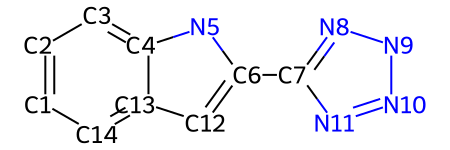

In [2]:
from rdkit.Chem.Draw import IPythonConsole
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Geometry.rdGeometry import Point2D
import io
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
from fuseprop import find_clusters, extract_subgraph, get_mol, get_smiles, find_fragments, find_fragments_with_scaffold, __extract_subgraph
from private import *

def GetBondPosition(mol, bond, return_atom_pos=False):
    if isinstance(bond, int):
        bond = mol.GetBondWithIdx(bond)
    conf = mol.GetConformer()
    idx1 = bond.GetBeginAtomIdx()
    idx2 = bond.GetEndAtomIdx()
    pos1 = conf.GetAtomPosition(idx1)
    pos2 = conf.GetAtomPosition(idx2)
    mid_x = (pos1.x + pos2.x) / 2
    mid_y = (pos1.y + pos2.y) / 2    
    if return_atom_pos:
        return mid_x, mid_y, pos1.x, pos1.y, pos2.x, pos2.y
    else:
        return mid_x, mid_y


def draw_smiles(smiles, ax=None, order=[]):
    mol = Chem.MolFromSmiles(smiles)
    for j, a in enumerate(mol.GetAtoms()):
        a.SetProp('atomLabel', f"{a.GetSymbol()}{j}")
    AllChem.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DCairo(600, 600)    
    options = drawer.drawOptions()  
    options.maxFontSize = 12
    options.atomLabelFontSize = 12
    drawer.DrawMolecule(mol) 
    drawer.SetFontSize(15)            
    for bond in mol.GetBonds():
        mid_x, mid_y = GetBondPosition(mol, bond)
        if bond.GetIdx() in order:
            index = order.index(bond.GetIdx())
            bond_label = f'({index+1}) bond_{bond.GetIdx()}'
        else:
            bond_label = f'bond_{bond.GetIdx()}'
        drawer.DrawString(bond_label, Point2D(mid_x, mid_y))
    drawer.FinishDrawing()
    # drawer.WriteDrawingText(os.path.join(dir_name, f'{i}.png'))
    img_data = drawer.GetDrawingText()
    if ax:
        image = io.BytesIO(img_data)
        img = plt.imread(image)
        ax.imshow(img)    
    else:
        from IPython.display import Image
        return Image(data=img_data)
    


def draw_cliques(cg, mol, ax=None, cq=None, label=True):
    """
    This function draws the cliques in cq, highlighting them in mol.
    Parameters:
        cg: clique graph, where nodes are bonds of mol, edges are atoms
        mol: the mol object to draw
        ax: if given, draw on ax
        cq: if given, draws predefined cliques, can be one of following:
            tuple (id, nodes, *color)
            list of tuples
        label: whether to annotate the id as text
    Output:
        Image drawn
    """
    for j, a in enumerate(mol.GetAtoms()):
        a.SetProp('atomLabel', f"{a.GetSymbol()}{j}")
    global_color = (1, 0, 0)
    AllChem.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DCairo(600, 600)    
    options = drawer.drawOptions()  
    options.noAtomLabels = True
    drawer.SetFillPolys(True)
    drawer.SetColour(global_color)
    options.maxFontSize = 20
    if cq:
        if isinstance(cq, tuple):
            cqs = [cq]
        else:
            assert isinstance(cq, list)
            cqs = cq
    else:
        cqs = list(enumerate(nx.find_cliques(cg)))
    for i, cq_arg in enumerate(cqs):
        if len(cq_arg) == 2:
            e, cq = cq_arg
            color = global_color
        else:
            e, cq, color = cq_arg
        x, y = 0, 0
        highlight_bond_map = {}
        for b in cq:
            bx, by = GetBondPosition(mol, b)
            x += bx
            y += by
            highlight_bond_map[b] = [color]      
        drawer.DrawMoleculeWithHighlights(mol, '', 
                                          highlight_atom_map={}, 
                                          highlight_bond_map=highlight_bond_map, 
                                          highlight_radii={}, 
                                          highlight_linewidth_multipliers={})
        if label: # TODO: Support len(cqs) > 1
            x /= len(cq)
            y /= len(cq)              
            label = f"e{e}"
            drawer.DrawString(label, Point2D(x, y))
    drawer.FinishDrawing()
    # drawer.WriteDrawingText(os.path.join(dir_name, f'{i}.png'))
    img_data = drawer.GetDrawingText()
    if ax:
        image = io.BytesIO(img_data)
        img = plt.imread(image)
        ax.imshow(img)    
    else:
        return Image(data=img_data)

# subgraphs = []
# subgraphs_idx_i = []
# clusters, atom_cls = find_clusters(mol)
# for i,cls in enumerate(clusters):
#     clusters[i] = set(list(cls))
# for i, cluster in enumerate(clusters):
#     _, subgraph_i_mapped, _ = extract_subgraph(smiles, cluster)
#     subgraphs.append(SubGraph(subgraph_i_mapped, mapping_to_input_mol=subgraph_i_mapped, subfrags=list(cluster)))
#     subgraphs_idx_i.append(list(cluster))
    


In [3]:
def mol_to_graph(mol):
    g = nx.Graph()
    for b in mol.GetBonds():
        g.add_node(b.GetIdx())
    for a in mol.GetAtoms():
        bs = [b.GetIdx() for b in a.GetBonds()]
        g.add_edges_from(product(bs, bs))
    g.remove_edges_from(nx.selfloop_edges(g))
    return g

class MolHG:
    def __init__(self, mol):
        if isinstance(mol, str):
            mol = Chem.MolFromSmiles(mol)
        self.mol = mol
        self.chordal_graph = self.llm_chordalize(mol)
    
    @staticmethod
    def llm_chordalize(mol):
        pass


In [4]:
def isRingAromatic(mol, bondRing):
    for id in bondRing:
        if not mol.GetBondWithIdx(id).GetIsAromatic():
            return False
    return True


def GetBondsAmongAtoms(mol, ring):
    return [mol.GetBondBetweenAtoms(i, j).GetIdx() for i in ring for j in ring if mol.GetBondBetweenAtoms(i, j)]    


def GetRingsWithBond(mol, b_idx):
    res = []
    for b_ring in mol.GetRingInfo().BondRings():
        add = False
        for idx in b_ring:
            if idx == b_idx:
                add = True
                break
        if add:
            res.append(b_ring)
    return res

# def get_clique_graph(mol):
#     g = mol_to_graph(mol)
#     for ring in mol.GetRingInfo().BondRings():
#         if isRingAromatic(mol, ring):
#             g.add_edges_from(product(ring, ring))
#     g.remove_edges_from(nx.selfloop_edges(g))
#     return g

def get_clique_graph(mol):
    g = mol_to_graph(mol)
    for ring in Chem.GetSymmSSSR(mol): # TODO
        ring = list(ring)
        ring = GetBondsAmongAtoms(mol, ring)
        g.add_edges_from(product(ring, ring))
    g.remove_edges_from(nx.selfloop_edges(g))
    return g

def my_complete_to_chordal(cg, mol):
    while True:
        try:            
            res, order = chordal._find_chordality_breaker(cg)
        except:
            break
        u, _, w = res
        u_rings = GetRingsWithBond(mol, u)
        w_rings = GetRingsWithBond(mol, w)
        if len(u_rings) > 1 or len(w_rings) > 1:
            breakpoint()
        else:
            u_r = u_rings[0]
            w_r = w_rings[0]
            print(u_r, w_r)
            cg.add_edges_from(product(u_r, w_r))
            cg.remove_edges_from(nx.selfloop_edges(cg))
    return cg


In [5]:
# smiles = 'C1=CC=C2[NH]C(C3=N[NH]N=N3)=CC2=C1'
# smiles = 'COC(=O)c1cc2csc(c3cc4c(s3)c(OC)c3ccsc3c4OC)c2s1'
smiles = 'C12(Cl)C(Cl)=C(Cl)C(Cl)(C1(Cl)Cl)C3C2C4CC3C5OC45'
def chordal_mol_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    cg = get_clique_graph(mol)
    # res, order = chordal._find_chordality_breaker(cg)
    # cg, _, chords = chordal.complete_to_chordal_graph(cg)
    cg = my_complete_to_chordal(cg, mol)
    assert chordal.is_chordal(cg)
    return mol, cg
    # chordal.chordal_graph_cliques(cg)    



In [6]:
def clique_drawing(cg, mol, path):
    # draw_cliques(cg, mol)
    cliques = list(nx.find_cliques(cg))
    n = len(cliques)
    d = int(np.sqrt(n))
    fig, axes = plt.subplots(d, n//d, figsize=(20, 20))
    axes = flatten(axes)
    for i, (cq, ax) in enumerate(zip(cliques, axes)):
        ax.axis('off')
        ax.set_title(f"{i}")
        draw_cliques(cg, mol, ax=ax, cq=(i, cq), label=False)
    fig.set_facecolor('white')
    fig.savefig(path, bbox_inches='tight', dpi=100)
    print(os.path.abspath(path))
    return cliques

(7, 10, 11, 19, 18) (1, 18, 7, 5, 3)
(7, 10, 11, 19, 18) (13, 12, 11, 20, 14)
(13, 12, 11, 20, 14) (13, 21, 22, 15, 14)
(16, 22, 17) (13, 21, 22, 15, 14)
/home/msun415/induction/data/api_mol_hg/41/0.png
/home/msun415/induction/data/api_mol_hg/41/1.png
/home/msun415/induction/data/api_mol_hg/41/2.png
/home/msun415/induction/data/api_mol_hg/41/3.png
/home/msun415/induction/data/api_mol_hg/41/4.png
/home/msun415/induction/data/api_mol_hg/41/5.png
False
/home/msun415/induction/data/api_mol_hg/42/0.png
/home/msun415/induction/data/api_mol_hg/42/1.png


True

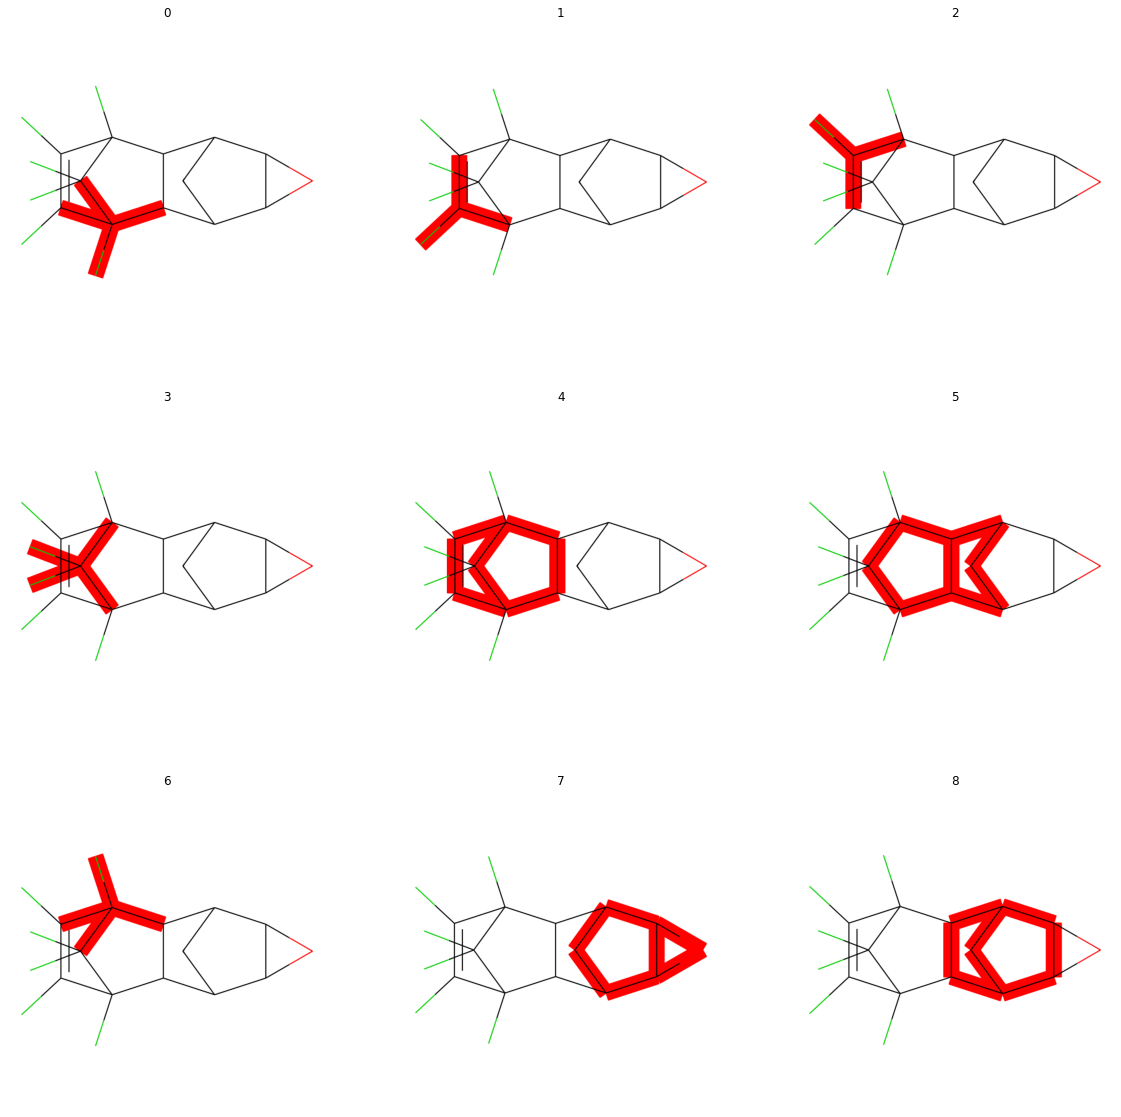

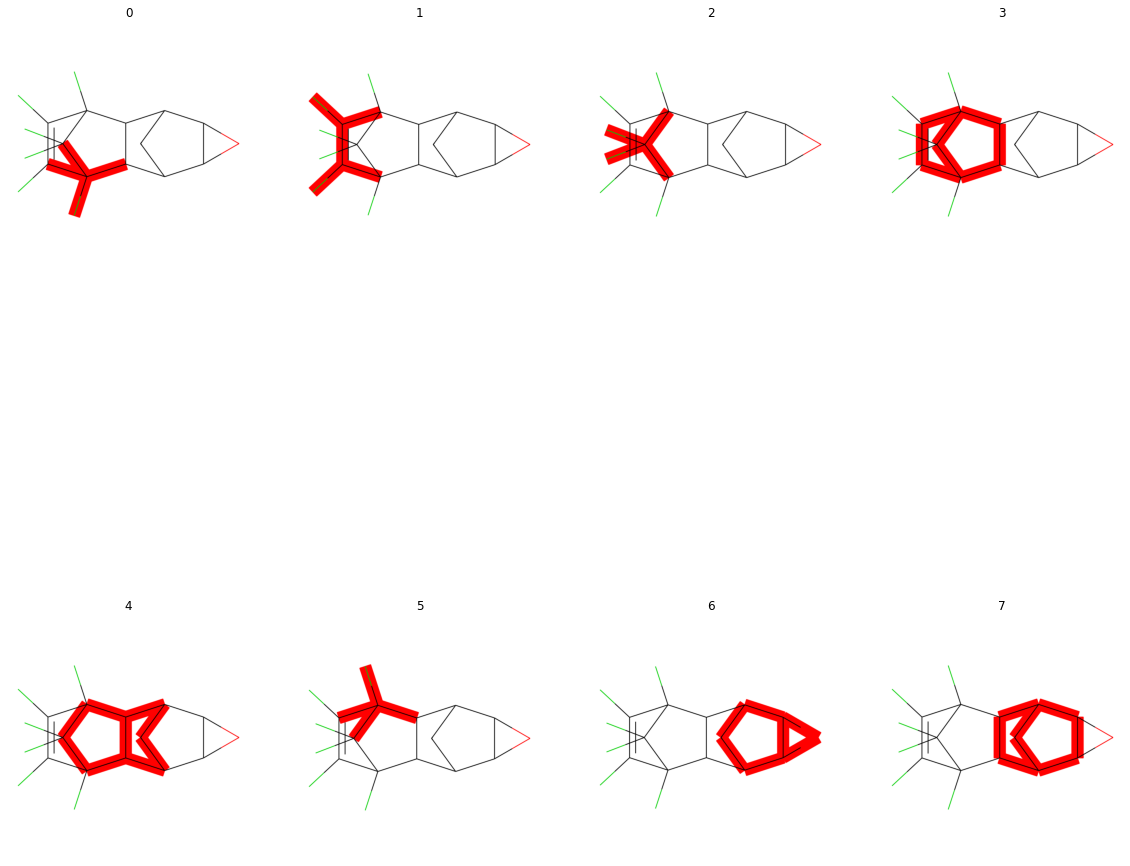

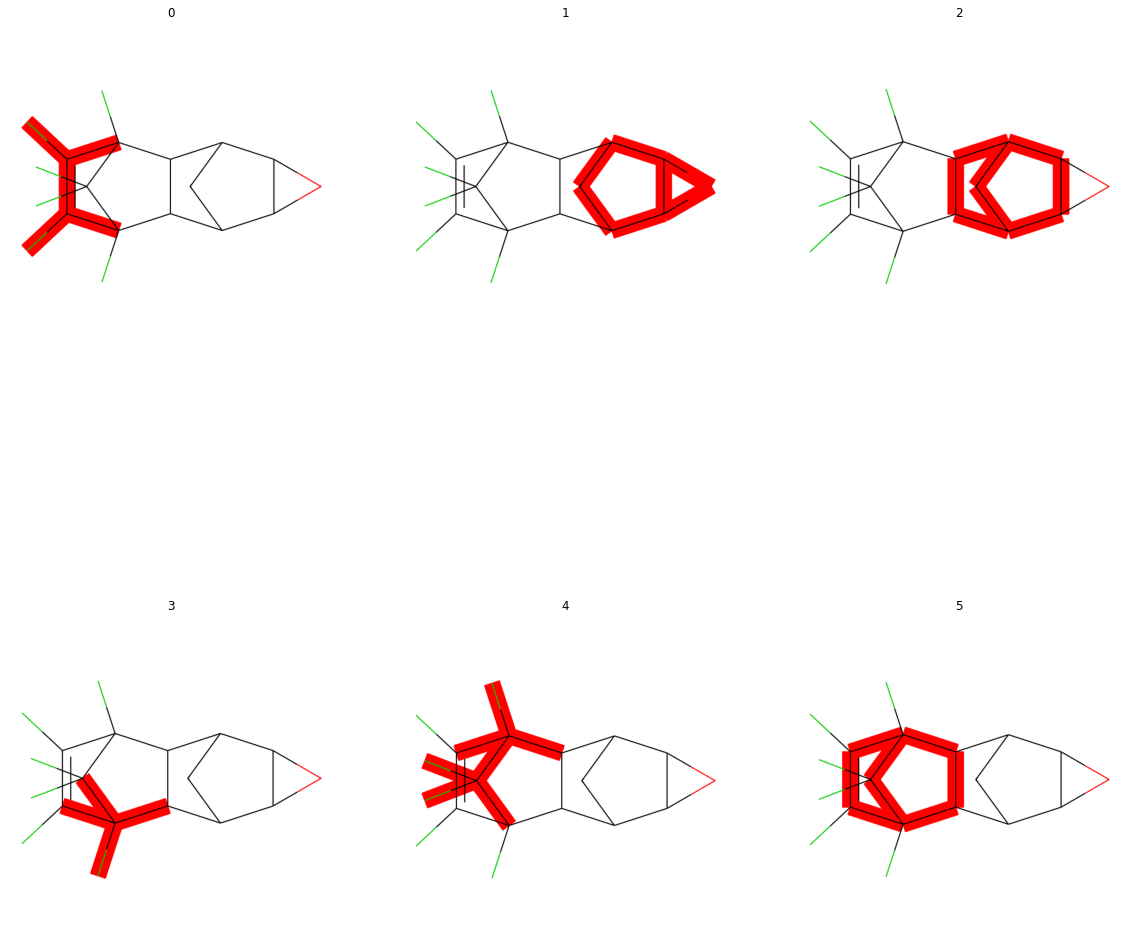

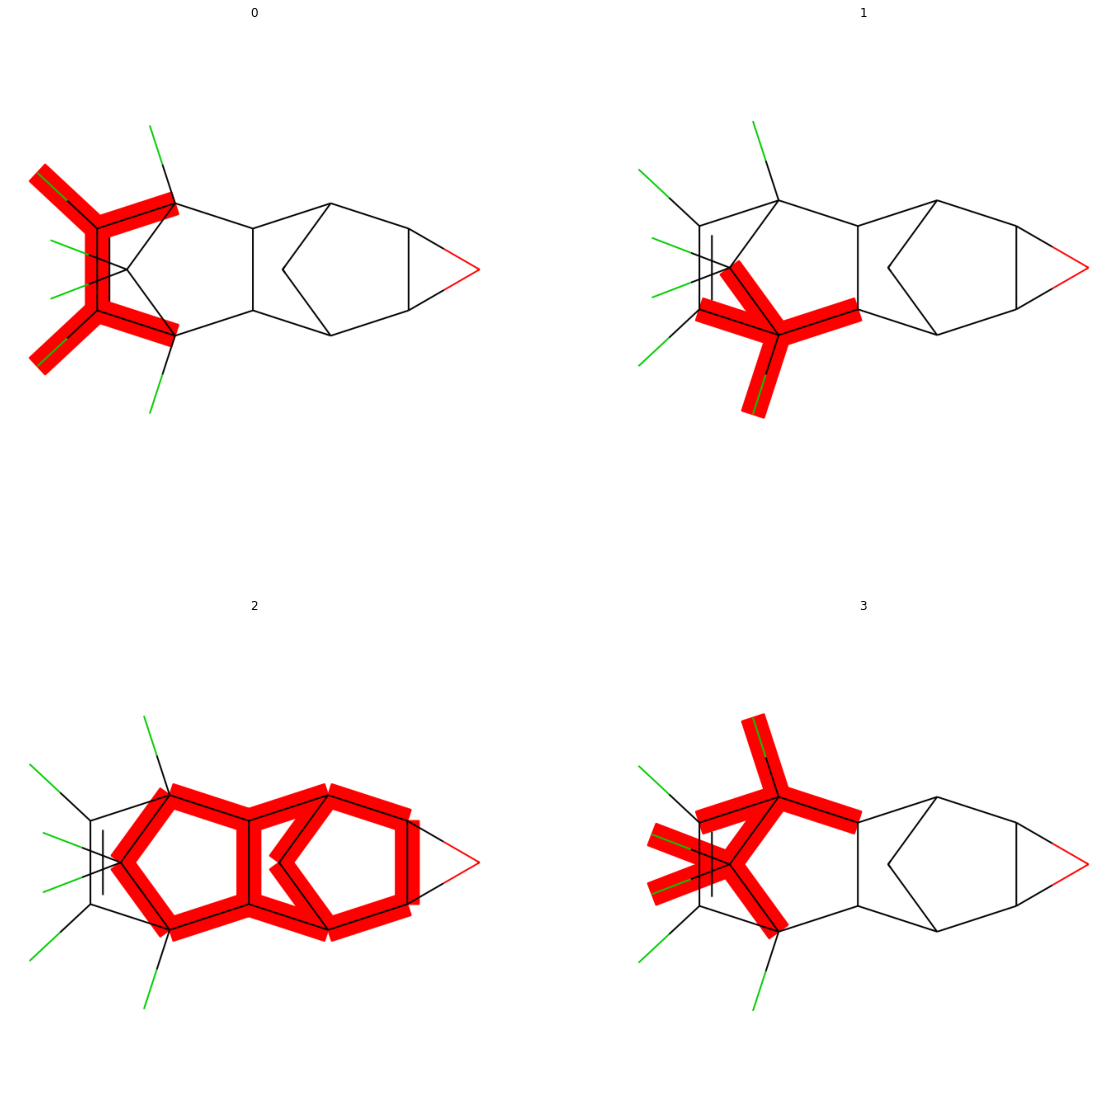

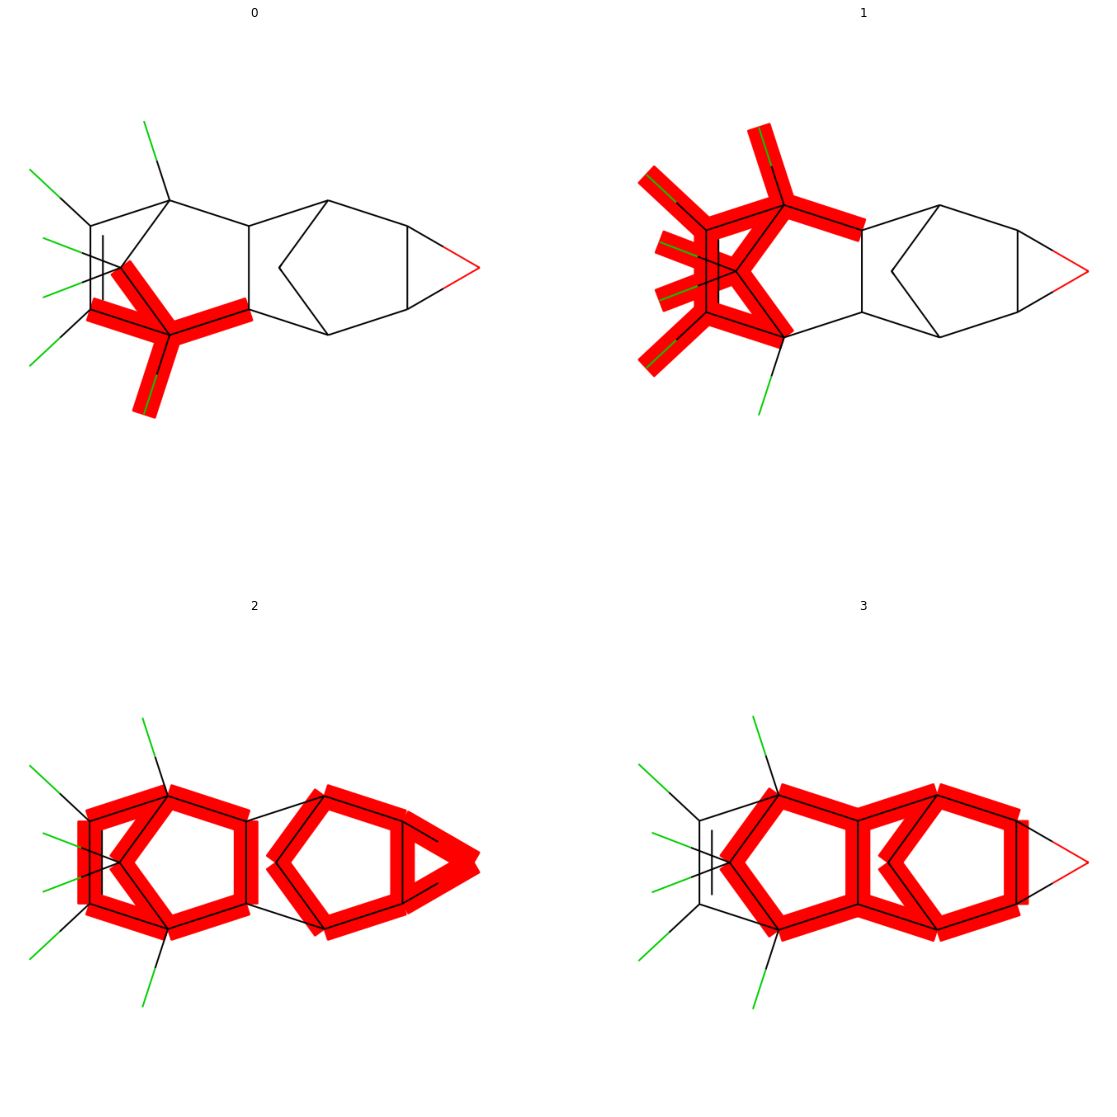

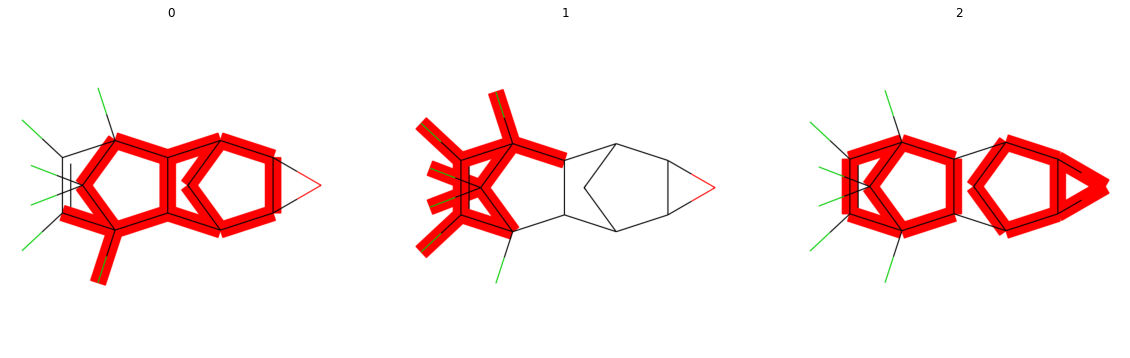

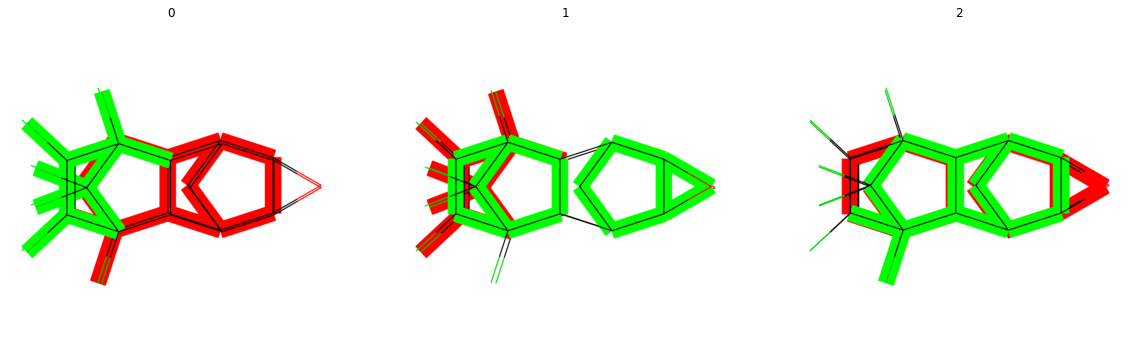

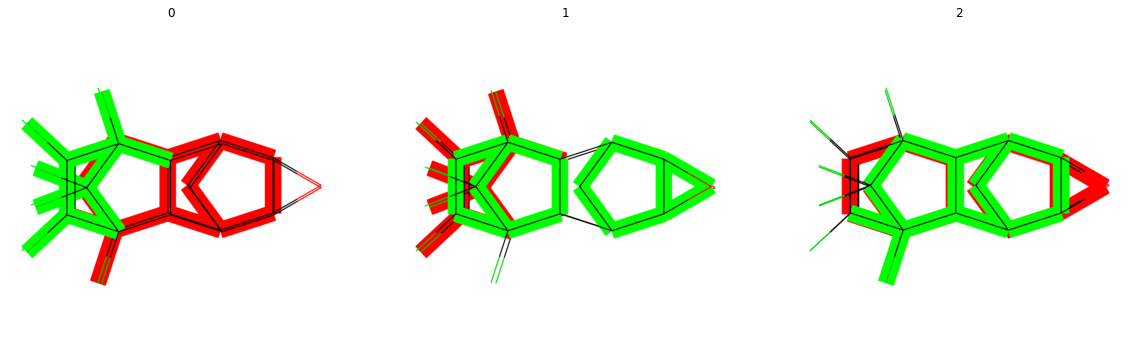

In [7]:
fig_dir = 'data/api_mol_hg/'
prompt_1_path = 'data/api_mol_hg_1.txt'
prompt_2_path = 'data/api_mol_hg_2.txt'
prompt_3_path = 'data/api_mol_hg_3.txt'

def get_next_version(fig_dir, dir=True):
    if dir:
        check = os.path.isdir
    else:
        check = os.path.isfile
    dirs = [d for d in os.listdir(fig_dir) if check(os.path.join(fig_dir, d))]
    if dir:
        versions = [int(d) for d in dirs]
    else:
        versions = [int(f.split('.')[0]) for f in dirs]
    return max(versions)+1 if len(versions) else 0


def llm_call(img_paths, prompt_path, optional_prompt=None):
    """
    This function uses prompt read from prompt_path and a list of img content.
    Parameters:
        img_paths: list of paths to img files
        prompt_path: a .txt file path
        optional_prompt: lambda function with single arg
        optional text prompt to process the output of the response
    Output:
        Response of call
    """
    base64_images = prepare_images(img_paths)
    prompt = ''.join(open(prompt_path).readlines())
    completion = openai.ChatCompletion.create(model="gpt-4o", 
        messages=[{"role": "user", 
                "content": [
                    {"type": "text",
                    "text": prompt}]+[
                        {"type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
                        } for base64_image in base64_images
                    ]}]
    )
    res = completion.choices[0].message.content    
    if optional_prompt:
        completion = openai.ChatCompletion.create(model="gpt-4o", 
            messages=[{"role": "user", 
                    "content": [
                        {"type": "text",
                        "text": optional_prompt(res)}]}]
        )
        res = completion.choices[0].message.content
    return res    
                                                     

def llm_choose_edit(img_path, prompt_path):
    post_prompt = lambda res: f"I want you to perform a simple data post-processing step of the following response:\n{res}\n The input is a response from another language agent. It may or may not contain an answer in the form of a single pair. If it does, output the pair in x,y format and NOTHING ELSE. Don't include explanations or superlatives. Just output the answer. If it doesn't contain an answer in the form of a pair, output the single word NONE."
    return llm_call([img_path], prompt_path, post_prompt)


def llm_edit_cliques(cg, mol, prompt_path):
    d = get_next_version(fig_dir)
    dir_name = os.path.join(fig_dir, f'{d}')
    os.makedirs(dir_name)
    while True:
        i = get_next_version(dir_name, dir=False)
        path = os.path.join(dir_name, f'{i}.png')
        cliques = clique_drawing(cg, mol, path)
        pair = llm_choose_edit(path, prompt_path)
        match = re.match(f"(\d+),(\d+)", pair)
        if match:
            e1 = int(match.groups()[0])
            e2 = int(match.groups()[1])
            if max(e1, e2) >= len(cliques):
                break
        else:
            break
        cq = cliques[e1]+cliques[e2]
        cg.add_edges_from(product(cq, cq))
        cg.remove_edges_from(nx.selfloop_edges(cg))    
    return cg, path


def llm_choose_root(img_path, prompt_path):
    post_prompt = lambda res: f"I want you to perform a simple data post-processing step of the following response:\n{res}\n The input is a response from another language agent. It may or may not contain an answer in the form of a single integer. If it does, output the integer and NOTHING ELSE. Don't include explanations or superlatives. Just output the answer. If it doesn't contain an answer in the form of a pair, output the single word NONE."
    root = llm_call([img_path], prompt_path, post_prompt)
    match = re.match(f"\d+", root)
    if match:
        return int(root)
    else:
        return 0


def init_tree(cg):
    tree = nx.Graph()
    for cq in nx.find_cliques(cg):
        tree.add_node(len(tree), nodes=cq)
    for n1 in tree:
        for n2 in tree:
            nodes1 = set(tree.nodes[n1]['nodes'])
            nodes2 = set(tree.nodes[n2]['nodes'])
            if nodes1 & nodes2:
                tree.add_edge(n1, n2, weight=len(nodes1 & nodes2))
    tree.remove_edges_from(nx.selfloop_edges(tree))
    return tree


def llm_break_edge(img_path, prompt_path):
    post_prompt = lambda res: f"I want you to perform a simple data post-processing step of the following response:\n{res}\n The input is a response from another language agent. It may or may not contain an answer in the form of a single integer. If it does, output the integer and NOTHING ELSE. Don't include explanations or superlatives. Just output the answer. If it doesn't contain an answer in the form of a pair, output the single word NONE."
    return llm_call([img_path], prompt_path, post_prompt)


def draw_cycle(cyc, tree, mol, path):
    n = len(cyc)
    d = int(np.sqrt(n))
    fig, axes = plt.subplots(d, n//d, figsize=(20, 20))
    axes = flatten(axes)
    for i, ((cq_1_id, cq_2_id), ax) in enumerate(zip(cyc, axes)):
        ax.axis('off')
        ax.set_title(f"{i}")
        cq_1 = tree.nodes[cq_1_id]['nodes']
        cq_2 = tree.nodes[cq_2_id]['nodes']
        draw_cliques(None, mol, ax, [(None, cq_1, (1, 0, 0)), (None, cq_2, (0, 1, 0))], label=False)
    fig.set_facecolor('white')
    fig.savefig(path, bbox_inches='tight', dpi=100)
    print(os.path.abspath(path))
    return path


def llm_break_cycles(tree, mol, root, prompt_path):
    d = get_next_version(fig_dir)
    dir_name = os.path.join(fig_dir, f'{d}')    
    os.makedirs(dir_name)
    while not nx.is_tree(tree):
        i = get_next_version(dir_name, dir=False)
        path = os.path.join(dir_name, f'{i}.png')
        cyc = nx.find_cycle(tree, root)
        if cyc:
            path = draw_cycle(cyc, tree, mol, path)
            e = llm_break_edge(path, prompt_path)
            match = re.match(f"\d+", e)
            if match:
                e = int(e)
                e1, e2 = cyc[e]
                tree.remove_edge(e1, e2)
        else:
            break
    return tree


mol, cg = chordal_mol_graph(smiles)
cg, path = llm_edit_cliques(cg, mol, prompt_1_path)
tree = init_tree(cg)
print(nx.is_tree(tree))
root = llm_choose_root(path, prompt_2_path)
tree = llm_break_cycles(tree, mol, root, prompt_3_path)
# tree = nx.maximum_spanning_tree(tree)
# while not nx.is_tree(tree):
nx.is_tree(tree)

In [8]:
tree.edges

EdgeView([(0, 1), (0, 2)])

In [9]:
root

0

In [1]:
from networkx.algorithms import chordal_graph_cliques, complete_to_chordal_graph
chordal_graph, _ = complete_to_chordal_graph(g)
# t = nx.junction_tree(g)
# fig, ax = plt.subplots(figsize=(20,20))
# pos = nx.spring_layout(t)
# nx.draw(t, pos, with_labels=True, ax=ax,)
cliques = [tuple(sorted(i)) for i in chordal_graph_cliques(chordal_graph)]
cliques

NameError: name 'g' is not defined

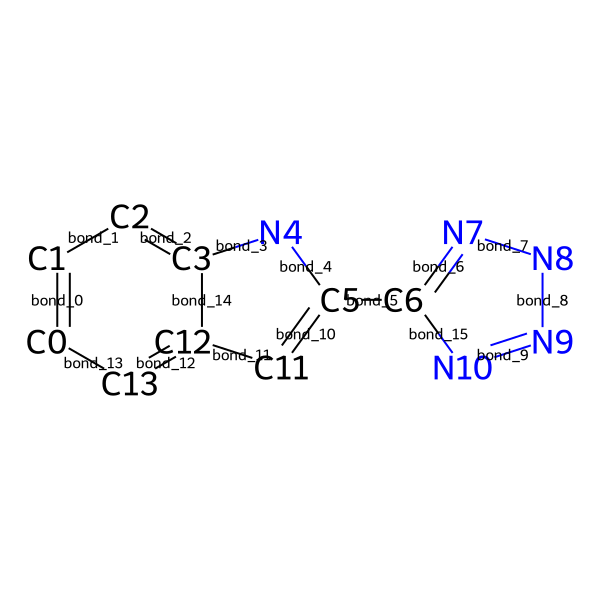

In [11]:
draw_smiles(smiles)

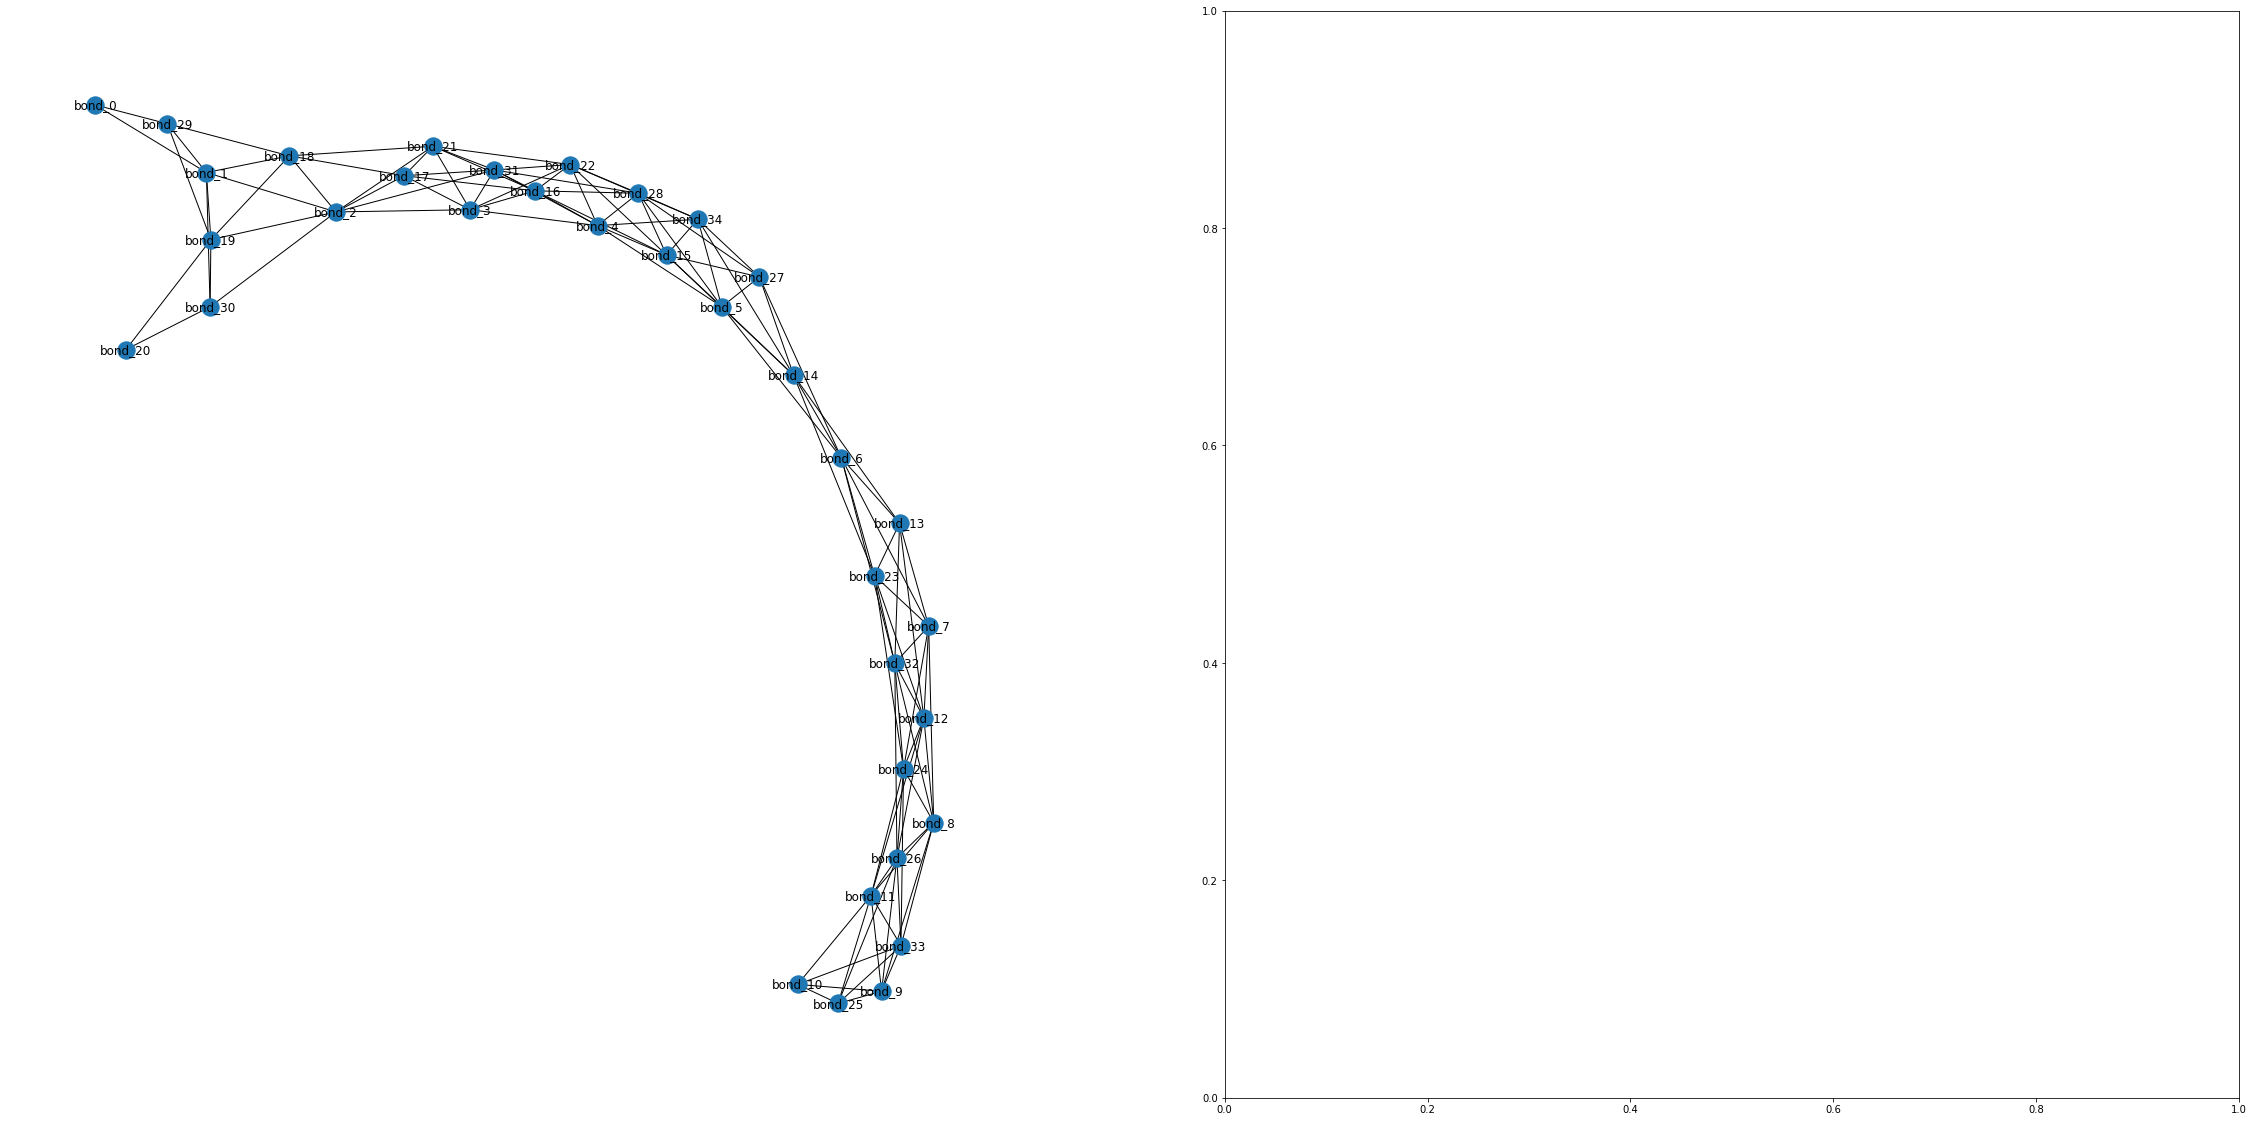

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
nx.draw(chordal_graph, with_labels=True, ax=ax1)

In [58]:
draw_smiles('C1=CC2=C3C=CC(=C4C=CC(=C5C=CC(=C6C=CC(=C1C=C2)C=C6)C=C5)C=C4)C=C3', ax2)

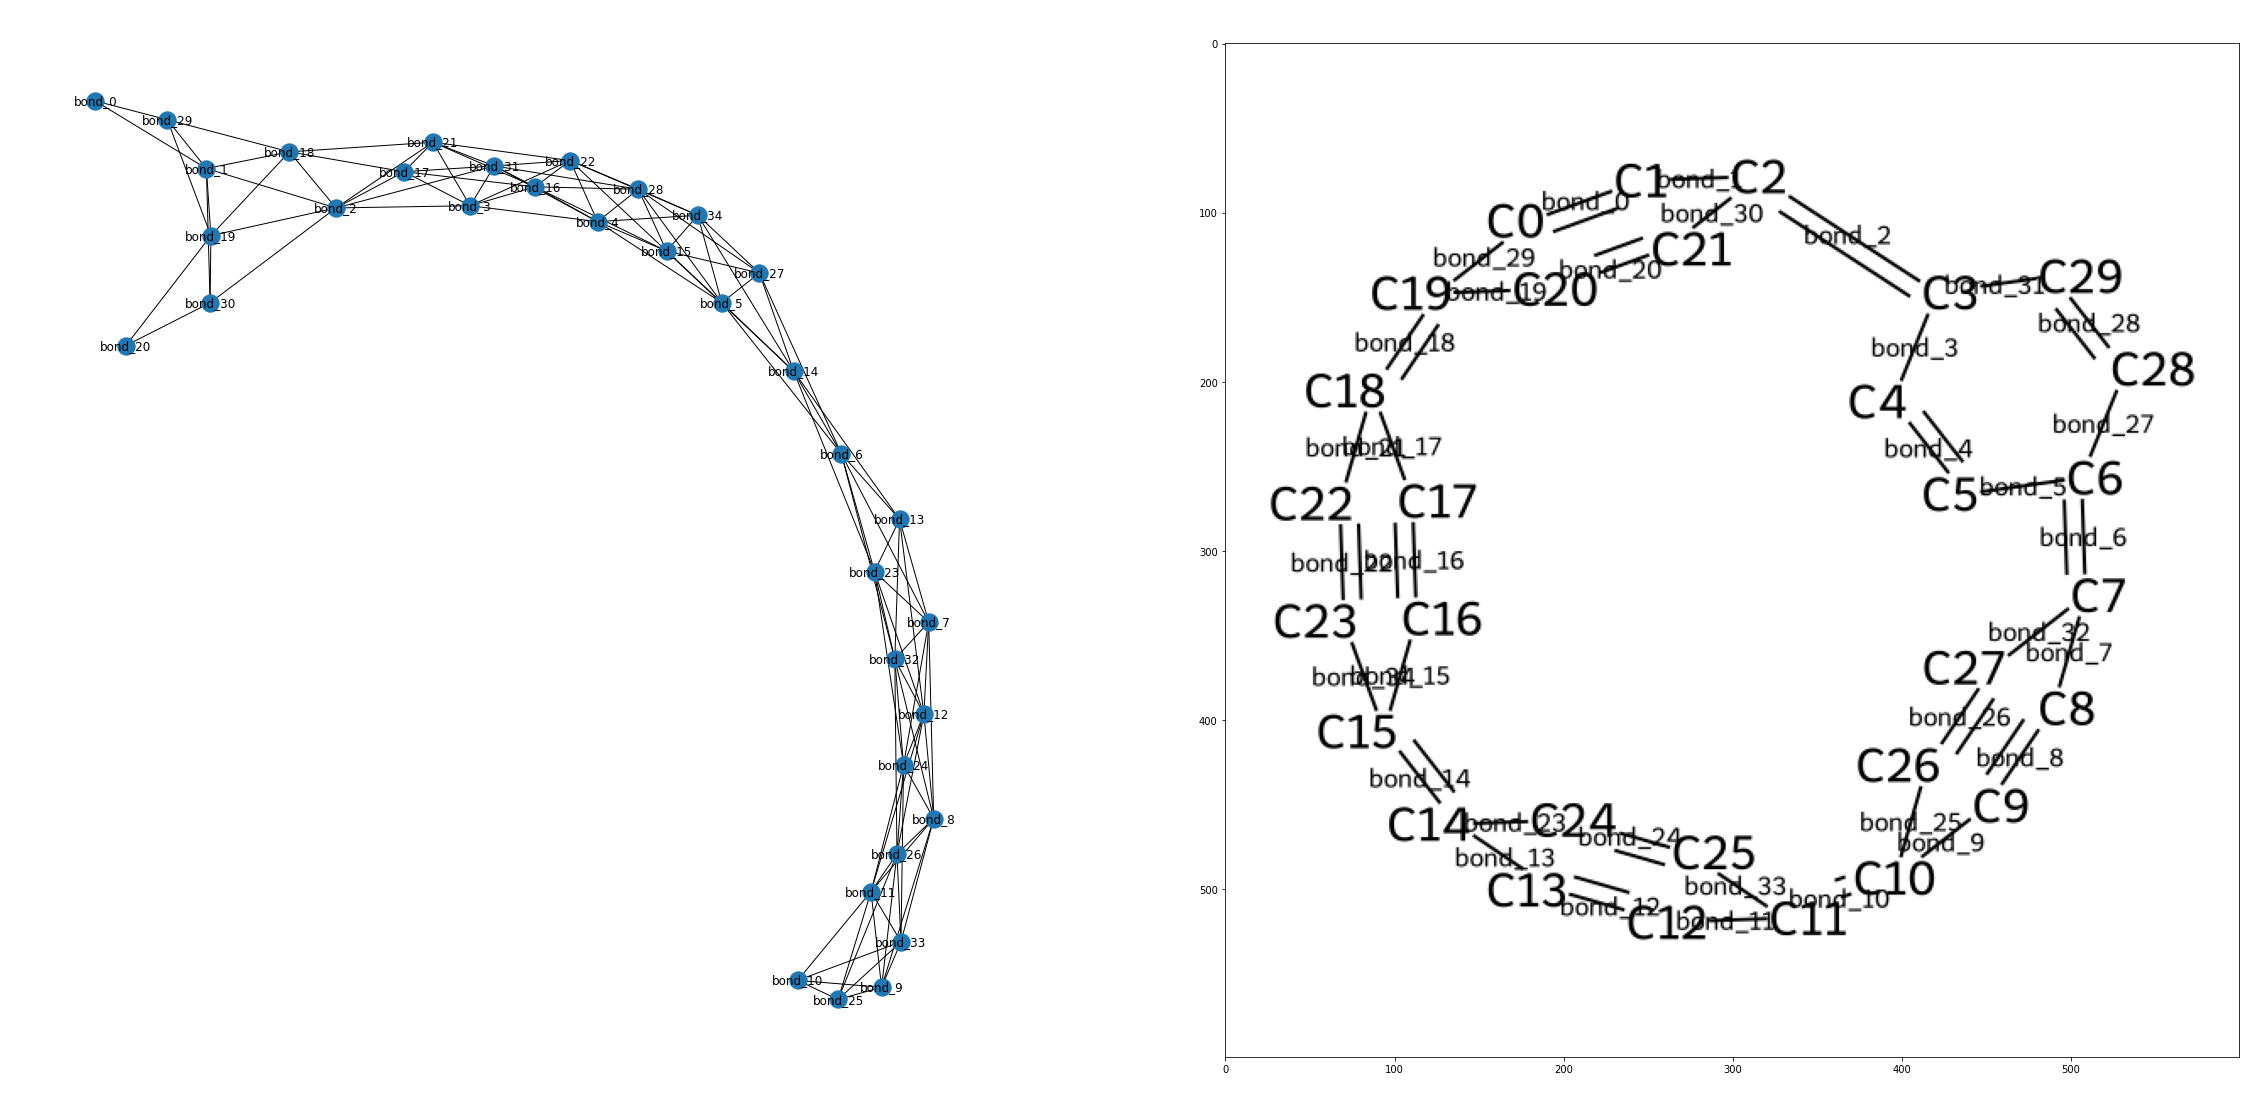

In [59]:
fig